In [12]:
#
# In this notebooks we make maps of data
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from src.plotting import *
from src.regions import *
from src.pf_stats import *
from src.daily import *
from src.cmorph import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
regions = [
    afc_region(), 
    cio_region(), 
    wmp_region(), 
    epo_region(),
    h01_region(), 
    sam_region(),
    sas_region(),
    h05_region(),
]
CORE_THRESH = 10
pf_stats = pd.concat(
    [load_pf_stats(r, maxpr_min=CORE_THRESH) for r in regions]
)


In [24]:
pf_stats[(pf_stats['max_precip']>=80)].shape[0]

37931

In [38]:
pf_stats['max_precip'].quantile(0.95)

66.74885406494124

In [25]:
37931/pf_stats.shape[0]

0.03356556350697354

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_4342/4249442408.py:69: RuntimeWarning: invalid value encountered in divide
  stat = N_exps / N_all * 100


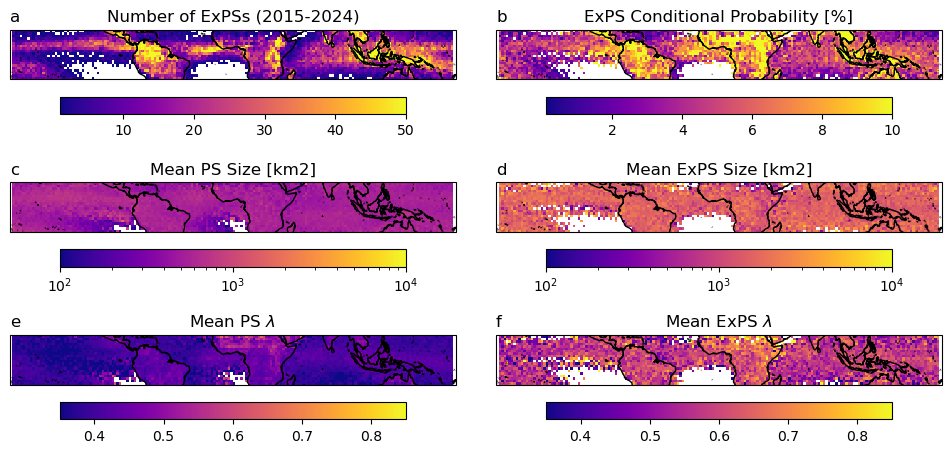

In [54]:
# Mapping system morphologies

fig, axs = plt.subplots(
    figsize=(10, 5),
    nrows=3, 
    ncols=2,
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ExPS_THRESH = 60
TyPS_MAX = np.inf
lat_bins = np.arange(-60, 60, 2)
lon_bins = np.arange(-180, 180, 2)

lon_mesh, lat_mesh = np.meshgrid(
    lon_bins, 
    lat_bins
)

for ai, ax in enumerate(axs.ravel()):
    #
    # Different axes show different data
    #
    exps_id = (pf_stats['max_precip']>=ExPS_THRESH)
    exps_stats = pf_stats[exps_id]

    typs_id = (
        (0<=pf_stats['max_precip'])
        & (pf_stats['max_precip']<=TyPS_MAX)
    )
    typs_stats = pf_stats[typs_id]

    match ai:

        # Num of ExPSs
        case 0:
            N_exps = binned_statistic_2d(
                exps_stats['mean_latitude'], 
                exps_stats['mean_longitude'], 
                None,
                bins=[lat_bins, lon_bins],
                statistic='count'
            ).statistic

            stat = N_exps
            cmap = plt.cm.plasma.copy()
            cmap.set_under('white')
            norm = colors.Normalize(vmin=1, vmax=50)
            title = 'Number of ExPSs (2015-2024)'

        # Frac of ExPSs to Total PSs
        case 1:
            N_exps = binned_statistic_2d(
                exps_stats['mean_latitude'], 
                exps_stats['mean_longitude'], 
                None,
                bins=[lat_bins, lon_bins],
                statistic='count'
            ).statistic

            N_all = binned_statistic_2d(
                pf_stats['mean_latitude'], 
                pf_stats['mean_longitude'], 
                None,
                bins=[lat_bins, lon_bins],
                statistic='count'
            ).statistic

            stat = N_exps / N_all * 100
            cmap = plt.cm.plasma.copy()
            cmap.set_under('white')
            norm = norm = colors.Normalize(vmin=1e-1, vmax=10)
            title = 'ExPS Conditional Probability [%]'

        # Mean Size of ExPSs
        case 3:
            size_exps = binned_statistic_2d(
                    exps_stats['mean_latitude'], 
                    exps_stats['mean_longitude'], 
                    exps_stats['num_pixels'] * 25,
                    bins=[lat_bins, lon_bins],
                    statistic=lambda x: np.nanmean(x)
                ).statistic
                       
            stat = size_exps
            cmap = plt.cm.plasma.copy()
            norm = colors.LogNorm(vmin=1e2, vmax=1e4)
            title = 'Mean ExPS Size [km2]'

        # Mean Size of PSs
        case 2: 
            size_typs = binned_statistic_2d(
                    typs_stats['mean_latitude'], 
                    typs_stats['mean_longitude'], 
                    typs_stats['num_pixels'] * 25,
                    bins=[lat_bins, lon_bins],
                    statistic=lambda x: np.nanmean(x)
                ).statistic
            stat = size_typs
            cmap = plt.cm.plasma.copy()
            norm = colors.LogNorm(vmin=1e2, vmax=1e4)
            title = 'Mean PS Size [km2]'
        
        # Change in loc
        case 5:
            loc_exps = binned_statistic_2d(
                    exps_stats['mean_latitude'], 
                    exps_stats['mean_longitude'], 
                    exps_stats[f'rainiest_{CORE_THRESH:0d}mmhr_cluster_precip_8conn'] / exps_stats['total_precip'],
                    bins=[lat_bins, lon_bins],
                    statistic=lambda x: np.nanmean(x)
                ).statistic
           
            stat = loc_exps
            cmap = plt.cm.plasma.copy()
            norm = colors.Normalize(vmin=0.35, vmax=0.85)
            title = r'Mean ExPS $\lambda$'


        case 4:
            loc_typs = binned_statistic_2d(
                    typs_stats['mean_latitude'], 
                    typs_stats['mean_longitude'], 
                    typs_stats[f'rainiest_{CORE_THRESH:0d}mmhr_cluster_precip_8conn'] / typs_stats['total_precip'],
                    bins=[lat_bins, lon_bins],
                    statistic=lambda x: np.nanmean(x)
                ).statistic
            
            
            stat = loc_typs
            cmap = plt.cm.plasma.copy()
            norm = colors.Normalize(vmin=0.35, vmax=0.85)
            title = r'Mean PS $\lambda$'



    #
    # Plot the stat
    #
    ax = axs[np.unravel_index(ai, axs.shape)]
    

    c = ax.pcolormesh(
        lon_mesh, 
        lat_mesh, 
        stat, 
        cmap=cmap, 
        norm=norm
    )
    ax.coastlines()

    ax.set_extent([-180, 180, -20, 20], crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.set_title(chr(ord('a') + ai), loc='left')
    cb = fig.colorbar(c, orientation='horizontal')
    

fig.tight_layout(pad=2.0)

save_figure(fig, 'Fig02_Maps')

In [49]:
exps_id.sum()

70588

In [51]:
N_exps.sum()

70588.0